# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
!nvidia-smi

Sat Feb 11 06:18:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     Off  | 00000000:3F:00.0 Off |                  Off |
| 33%   28C    P8     8W / 260W |      0MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import os
import imageio
import datetime
import os
import abc
from sys import getsizeof
import cv2 
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout
from PIL import Image,ImageFilter, ImageEnhance
import scipy
import warnings
import random
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [4]:
project_folder='/home/datasets/Project_data'
train_doc = np.random.permutation(open(project_folder+'/train.csv').readlines())
val_doc = np.random.permutation(open(project_folder+'/val.csv').readlines())
batch_size = 30

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size, img_idx=list(range(0, 29, 1)), xdim=120, ydim=120, channels=3, enhanceandaugment=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size, 'Channels = ', channels, 'Enhance And Augment = ', enhanceandaugment)    
    while True:
        t = np.random.permutation(folder_list)       
        # The number of folders/videos may not always be divisible by our batch size. If that is the case, we will endup with one extra batch with 
        # lesser folders. We need to consider that too.
        if (len(t)%batch_size) == 0:
            num_batches = len(t)//batch_size
        else:
            num_batches = len(t)//batch_size + 1 
            
        for batch in range(num_batches): # we iterate over the number of batches
            if enhanceandaugment == True:
                augidx=(len(img_idx)*2)+1
            else:
                augidx=(len(img_idx))
                
            batch_data = np.zeros((batch_size,augidx,xdim,ydim,channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size                
                if folder + (batch*batch_size) >= len(t): # we need to exit as the last batch may not have complete batch size of data
                    break                
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resized= cv2.resize(image,(xdim,ydim))  
                    if enhanceandaugment == True:
                        enh_type=random.randint(0,3)
                        if enh_type == 0: # edge Enhancement
                            image_aug = np.array(Image.fromarray(image_resized, 'RGB').filter(ImageFilter.EDGE_ENHANCE))                        
                        elif enh_type == 1: # enchancing image detailing
                            image_aug = np.array(Image.fromarray(image_resized, 'RGB').filter(ImageFilter.DETAIL))
                        elif enh_type == 2: # sharpening image
                            sharpen_filter=np.array([[-1,-1,-1],
                         [-1,9,-1],
                         [-1,-1,-1]])
                            # applying kernels to the input image to get the sharpened image                        
                            image_aug=cv2.filter2D(image_resized,-1,sharpen_filter)
                        elif enh_type == 3: # Brightness enhancement
                            image_aug = np.array(ImageEnhance.Brightness((Image.fromarray(image_resized, 'RGB'))).enhance(1.5))
                    for channel in range(channels):                      
                        batch_data[folder,idx,:,:,channel] = (image_resized[:,:,channel])/255 #normalise and feed in the image
                        if enhanceandaugment == True:
                            batch_data[folder,idx+30,:,:,channel]=(image_aug[:,:,channel])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


### Check if the data generator is loading the batch correctly, render an image and verify its class

In [6]:
g = generator(project_folder+'/train',train_doc,batch_size,channels=3, enhanceandaugment=True)

In [7]:
batch_data, batch_labels=next(g)

Source path =  /home/datasets/Project_data/train ; batch size = 30 Channels =  3 Enhance And Augment =  True


In [8]:
batch_data.shape # we have batch size of 30 sequences with 30 original images + enhanced and augmented images within each sequence. 

(30, 59, 120, 120, 3)

In [9]:
batch_labels.shape # we have 10 records with 5 classes as per the 5 gestures we have in our problem

(30, 5)

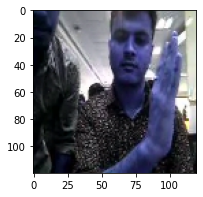

In [10]:
plt.figure(figsize=(3,3))
plt.imshow(batch_data[-1][10])
plt.show()

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [11]:
curr_dt_time = datetime.datetime.now()
train_path = project_folder+'/train'
val_path = project_folder+'/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D, GlobalAveragePooling3D,GlobalAveragePooling2D, ConvLSTM2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

## Model 1

Epoch = 15, batch size = 30, with image of 120 x 120 with 3 channels. No enhancement and augmentation
.Convulation layers with 2,2,2 kernels with dropout layers, batch normalization

In [13]:
model = Sequential()

model.add(Conv3D(32, (2, 2, 2), padding='same',input_shape=(30,120,120,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
#drop out
model.add(Dropout(0.5))
# flatten
model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

2023-02-11 06:18:51.419788: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-02-11 06:18:51.419868: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22851 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3f:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [14]:
optimiser = 'adam' 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 32)  800       
                                                                 
 activation (Activation)     (None, 30, 120, 120, 32)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 32)  128      
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 60, 64)    16448     
                                                                 
 activation_1 (Activation)   (None, 15, 60, 60, 64)    0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [15]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [16]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)  # write the REducelronplateau code here
#callbacks_list = [checkpoint, LR]
callbacks_list = [LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [17]:
def getstepsperepochandvalidation():
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
        
    return steps_per_epoch, validation_steps
        
steps_per_epoch, validation_steps=getstepsperepochandvalidation()

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [18]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 30 Channels =  3 Enhance And Augment =  False
Epoch 1/15


2023-02-11 06:18:54.851799: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - 45s 2s/step - loss: 1.0955 - categorical_accuracy: 0.5580 - val_loss: 4.2504 - val_categorical_accuracy: 0.1750 - lr: 0.0010
Epoch 2/15
23/23 [==============================] - 42s 2s/step - loss: 0.3773 - categorical_accuracy: 0.8493 - val_loss: 8.3502 - val_categorical_accuracy: 0.1917 - lr: 0.0010
Epoch 3/15
23/23 [==============================] - 41s 2s/step - loss: 0.2259 - categorical_accuracy: 0.9101 - val_loss: 9.3576 - val_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 4/15
23/23 [==============================] - 40s 2s/step - loss: 0.1531 - categorical_accuracy: 0.9246 - val_loss: 5.4618 - val_categorical_accuracy: 0.1833 - lr: 0.0010
Epoch 5/15
23/23 [==============================] - 41s 2s/step - loss: 0.1454 - categorical_accuracy: 0.9203 - val_loss: 8.5863 - val_categorical_accuracy: 0.3167 - lr: 0.0010
Epoch 6/15
23/23 [==============================] - 42s 2s/step - loss: 0.0694 - categorical_accuracy: 0.9551 - val_loss: 5.15

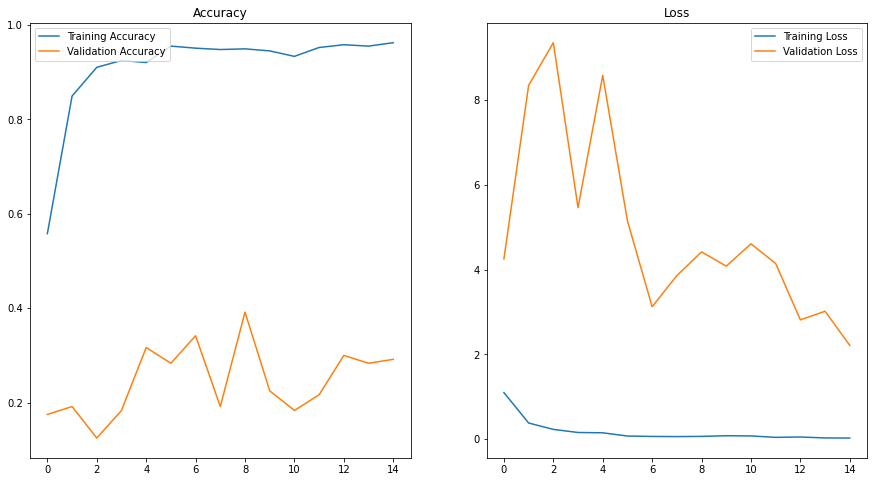

In [19]:
def plotaccuracyandloss(epocs):
    epochs_range = range(epocs)
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history.history['categorical_accuracy'], label='Training Accuracy')
    plt.plot(epochs_range, history.history['val_categorical_accuracy'], label='Validation Accuracy')
    plt.legend(loc='upper left')
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['loss'], label='Training Loss')
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')
    plt.show()
    
plotaccuracyandloss(num_epochs)

# Observation
 model is clearly overfit. Training accuracy is around 95% but validation accuracy is around 39% at epoch 9

# Model 2
Epoch = 30, batch size = 40, with image of 100 x 100 with single channel. No enhancement and augmentation
Convulation layers with 2,2,2 kernels with dropout layers, batch normalization. We are considering only 15 images out of 30

A model with higher batch size, epochs with single channel and reduced dimension of image.

In [20]:
batch_size=40
num_epochs=30
train_generator = generator(train_path, train_doc, batch_size,img_idx=list(range(0, 29, 2)),xdim=100,ydim=100,channels=1)
val_generator = generator(val_path, val_doc, batch_size,img_idx=list(range(0, 29, 2)),xdim=100,ydim=100,channels=1)

In [21]:
model = Sequential()

model.add(Conv3D(32, (2, 2, 2), padding='same',input_shape=(15,100,100,1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
#drop out
model.add(Dropout(0.5))
# flatten
model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [22]:
optimiser = 'adam' 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 15, 100, 100, 32)  288       
                                                                 
 activation_3 (Activation)   (None, 15, 100, 100, 32)  0         
                                                                 
 batch_normalization_4 (Batc  (None, 15, 100, 100, 32)  128      
 hNormalization)                                                 
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 7, 50, 50, 32)    0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 7, 50, 50, 64)     16448     
                                                                 
 activation_4 (Activation)   (None, 7, 50, 50, 64)    

In [23]:
steps_per_epoch, validation_steps=getstepsperepochandvalidation()

In [24]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 40 Channels =  1 Enhance And Augment =  False
Epoch 1/30
17/17 [==============================] - 18s 1s/step - loss: 1.1725 - categorical_accuracy: 0.5265 - val_loss: 1.7701 - val_categorical_accuracy: 0.1750 - lr: 0.0010
Epoch 2/30
17/17 [==============================] - 17s 1s/step - loss: 0.5484 - categorical_accuracy: 0.7853 - val_loss: 3.2285 - val_categorical_accuracy: 0.1750 - lr: 0.0010
Epoch 3/30
17/17 [==============================] - 17s 1s/step - loss: 0.3411 - categorical_accuracy: 0.8735 - val_loss: 3.5073 - val_categorical_accuracy: 0.1917 - lr: 0.0010
Epoch 4/30
17/17 [==============================] - 17s 1s/step - loss: 0.1580 - categorical_accuracy: 0.9309 - val_loss: 4.3203 - val_categorical_accuracy: 0.1750 - lr: 0.0010
Epoch 5/30
17/17 [==============================] - 16s 1s/step - loss: 0.0860 - categorical_accuracy: 0.9779 - val_loss: 4.5670 - val_categorical_accuracy: 0.1667 - lr: 0.0010
Epoch

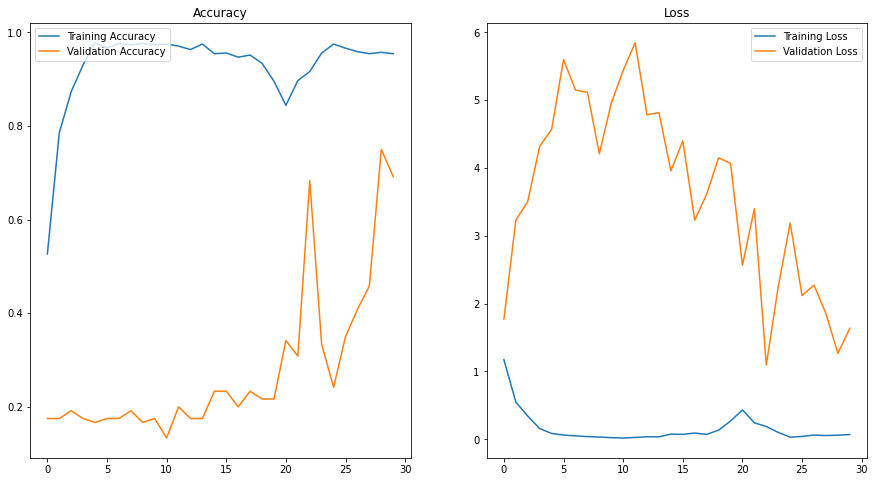

In [25]:
plotaccuracyandloss(num_epochs)

# Observation
 Model is still overfit. Training accuracy is around 95.75% but validation accuracy is around 75%. It is better than Model 1 considering only 1 channel data was provided, half number of images were considered in sequence. Training time per epoch was significantly lower than Model 1

# Model 3
Epoch = 30, batch size = 30, with image of 120 x 120 with 3 channels. No enhancement and augmentation
Convulation layers with 3,3,3 kernels with dropout layers, batch normalization. We are considering all of the 30 images

A model with higher convulation layers

In [26]:
batch_size=30
num_epochs=30
train_generator = generator(train_path, train_doc, batch_size,img_idx=list(range(0, 29, 1)),xdim=120,ydim=120,channels=3)
val_generator = generator(val_path, val_doc, batch_size,img_idx=list(range(0, 29, 1)),xdim=120,ydim=120,channels=3)

In [27]:
model = Sequential()

model.add(Conv3D(32, (3, 3, 3), padding='same',input_shape=(30,120,120,3)))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(256, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(512, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv3D(512, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))

#drop out
model.add(Dropout(0.5))
# flatten
model.add(Flatten())

model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [28]:
optimiser = 'adam' 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 30, 120, 120, 32)  2624      
                                                                 
 activation_6 (Activation)   (None, 30, 120, 120, 32)  0         
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 15, 60, 60, 32)   0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 15, 60, 60, 64)    55360     
                                                                 
 activation_7 (Activation)   (None, 15, 60, 60, 64)    0         
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 7, 30, 30, 64)    0         
 3D)                                                  

In [29]:
steps_per_epoch, validation_steps=getstepsperepochandvalidation()

In [30]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 30 Channels =  3 Enhance And Augment =  False
Epoch 1/30
23/23 [==============================] - 45s 2s/step - loss: 1.6865 - categorical_accuracy: 0.2928 - val_loss: 16.5494 - val_categorical_accuracy: 0.1917 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - 41s 2s/step - loss: 1.4239 - categorical_accuracy: 0.3913 - val_loss: 13.5247 - val_categorical_accuracy: 0.2333 - lr: 0.0010
Epoch 3/30
23/23 [==============================] - 41s 2s/step - loss: 1.2419 - categorical_accuracy: 0.4522 - val_loss: 4.9025 - val_categorical_accuracy: 0.2417 - lr: 0.0010
Epoch 4/30
23/23 [==============================] - 41s 2s/step - loss: 1.2545 - categorical_accuracy: 0.4275 - val_loss: 14.6784 - val_categorical_accuracy: 0.1917 - lr: 0.0010
Epoch 5/30
23/23 [==============================] - 41s 2s/step - loss: 1.2216 - categorical_accuracy: 0.4551 - val_loss: 8.4640 - val_categorical_accuracy: 0.1917 - lr: 0.0010
Ep

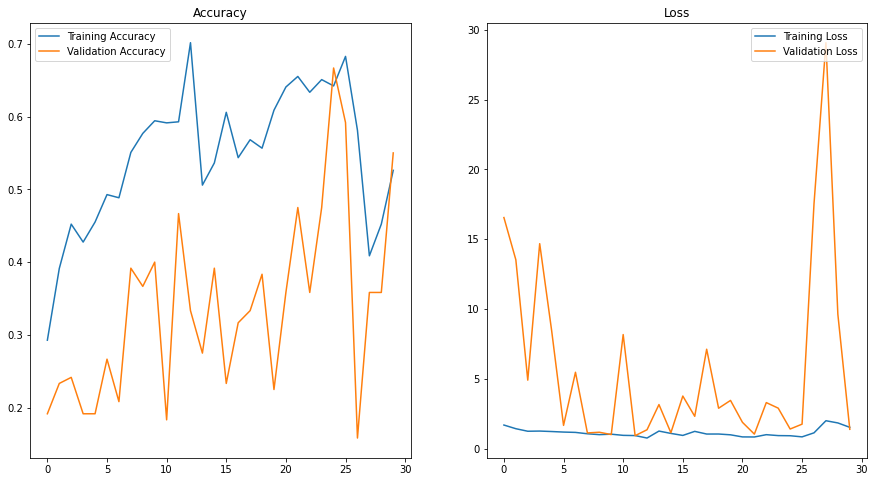

In [31]:
plotaccuracyandloss(num_epochs)

# Observation
Model accuracy dropped. The model is still overfit. At epoch 26, the model had an accuracy of 68.2% with validation accuracy of 59%

# Model 4

Epoch = 50, batch size = 10, with image of 120 x 120 with 3 channels. With enhancement and augmentation.
Convulation layers with 1,1,1, 2,2,2 and 3,3,3 kernels with dropout layers, batch normalization. We are considering 59 images post augmentation per sequence. A model with higher convulation layers and mix of kernel sizes. When batch size was increased and image size was increased to 150x150, the model failed to train due to memory issues.

In [32]:
batch_size=10
num_epochs=50
train_generator = generator(train_path, train_doc, batch_size,img_idx=list(range(0, 29, 1)),xdim=120,ydim=120,channels=3,enhanceandaugment=True)
val_generator = generator(val_path, val_doc, batch_size,img_idx=list(range(0, 29, 1)),xdim=120,ydim=120,channels=3, enhanceandaugment=True)

In [33]:
model = Sequential()

model.add(Conv3D(32, kernel_size=(1,1,1), activation='relu', input_shape=(30,120,120,3)))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(128, kernel_size=(1,1,1), activation='relu'))
model.add(Conv3D(128, kernel_size=(2,2,2), activation='relu'))
model.add(Conv3D(128, kernel_size=(3,3,3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(256, kernel_size=(1,1,1), activation='relu'))
model.add(Conv3D(256, kernel_size=(2,2,2), activation='relu'))
model.add(Conv3D(256, kernel_size=(3,3,3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GlobalAveragePooling3D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [34]:
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 30, 120, 120, 32)  128       
                                                                 
 conv3d_13 (Conv3D)          (None, 28, 118, 118, 64)  55360     
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 14, 59, 59, 64)   0         
 g3D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 14, 59, 59, 64)   256       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 14, 59, 59, 64)    0         
                                                                 
 conv3d_14 (Conv3D)          (None, 14, 59, 59, 128)  

In [35]:
steps_per_epoch, validation_steps=getstepsperepochandvalidation()

In [36]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 10 Channels =  3 Enhance And Augment =  True
Epoch 1/50
67/67 [==============================] - 101s 1s/step - loss: 1.6090 - categorical_accuracy: 0.3821 - val_loss: 1.9402 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 2/50
67/67 [==============================] - 85s 1s/step - loss: 1.2247 - categorical_accuracy: 0.4701 - val_loss: 2.3956 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/50
67/67 [==============================] - 85s 1s/step - loss: 1.1863 - categorical_accuracy: 0.5030 - val_loss: 2.4772 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 4/50
67/67 [==============================] - 83s 1s/step - loss: 1.0641 - categorical_accuracy: 0.5701 - val_loss: 2.5322 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 5/50
67/67 [==============================] - 84s 1s/step - loss: 1.0171 - categorical_accuracy: 0.5627 - val_loss: 2.5873 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch

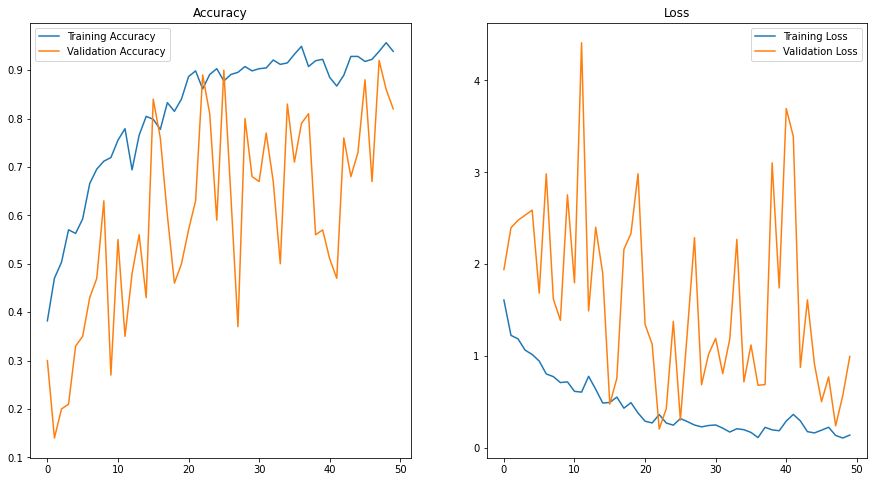

In [37]:
plotaccuracyandloss(num_epochs)

# Observation
training accuracy 93% with validation accuracy of around 92% at epoch 48. This is an excellent model using Conv3D. Lower batch size and more layers with augmentation resulted in higher learning time per epoch. Let us now try Conv2D+ GRU or LSTM

# Model 5 Conv2D + GRU
Epoch = 100, batch size = 30, with image of 120 x 120 with 3 channels. With enhancement and augmentation
Conv2D + GRU

In [14]:
batch_size=30
num_epochs=50
train_generator = generator(train_path, train_doc, batch_size,img_idx=list(range(0, 29, 1)),xdim=120,ydim=120,channels=3,enhanceandaugment=True)
val_generator = generator(val_path, val_doc, batch_size,img_idx=list(range(0, 29, 1)),xdim=120,ydim=120,channels=3,enhanceandaugment=True)

In [15]:
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=(59,120,120,3)))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GRU(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

2023-02-10 15:42:27.822272: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-02-10 15:42:27.822356: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22851 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [16]:
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 59, 118, 118, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 59, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization (BatchN  (None, 59, 59, 59, 32)   128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 59, 59, 59, 32)    0         
                                                                 
 time_distributed_2 (TimeDis  (None, 59, 57, 57, 64)   18496     
 tributed)                                              

In [25]:
steps_per_epoch, validation_steps=getstepsperepochandvalidation()

In [26]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 30 Channels =  3 Enhance And Augment =  True
Epoch 1/50


2023-02-10 15:45:14.814428: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - 66s 3s/step - loss: 1.5045 - categorical_accuracy: 0.3449 - val_loss: 1.3347 - val_categorical_accuracy: 0.1583 - lr: 0.0010
Epoch 2/50
23/23 [==============================] - 60s 3s/step - loss: 1.2285 - categorical_accuracy: 0.4594 - val_loss: 1.3272 - val_categorical_accuracy: 0.1917 - lr: 0.0010
Epoch 3/50
23/23 [==============================] - 59s 3s/step - loss: 1.0789 - categorical_accuracy: 0.5435 - val_loss: 1.3906 - val_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 4/50
23/23 [==============================] - 61s 3s/step - loss: 0.9747 - categorical_accuracy: 0.5957 - val_loss: 1.4200 - val_categorical_accuracy: 0.1833 - lr: 0.0010
Epoch 5/50
23/23 [==============================] - 60s 3s/step - loss: 0.9377 - categorical_accuracy: 0.5841 - val_loss: 1.5605 - val_categorical_accuracy: 0.1750 - lr: 0.0010
Epoch 6/50
23/23 [==============================] - 60s 3s/step - loss: 0.8354 - categorical_accuracy: 0.6232 - val_loss: 1.78

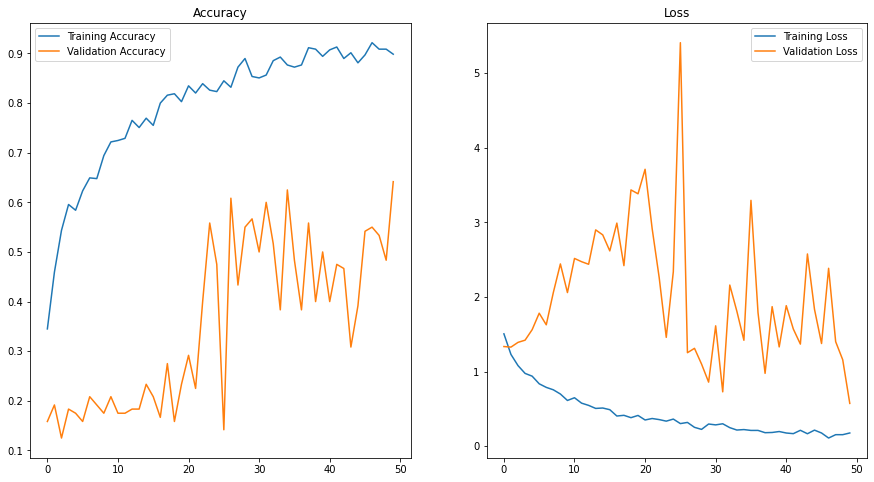

In [29]:
plotaccuracyandloss(num_epochs)

In [ ]:
#Observation
The model is over fit. Training accuracy of 90% with validation accuracy of 64%.

# Model 6 Conv2D + LSTM
model with convolution layer and LSTM

In [38]:
batch_size=20
num_epochs=50
train_generator = generator(train_path, train_doc, batch_size,img_idx=list(range(0, 29, 1)),xdim=120,ydim=120,channels=3,enhanceandaugment=True)
val_generator = generator(val_path, val_doc, batch_size,img_idx=list(range(0, 29, 1)),xdim=120,ydim=120,channels=3,enhanceandaugment=True)

In [39]:
model = Sequential()
model.add(TimeDistributed(Conv2D(8, (3,3), activation='relu'), input_shape=(59,120,120,3)))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu')))
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu')))
model.add(BatchNormalization())
model.add(ConvLSTM2D(8, kernel_size = 3, return_sequences=False))
model.add(BatchNormalization())
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(TimeDistributed(Dense(128, activation='relu')))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [40]:
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_11 (TimeDi  (None, 59, 118, 118, 8)  224       
 stributed)                                                      
                                                                 
 batch_normalization_8 (Batc  (None, 59, 118, 118, 8)  32        
 hNormalization)                                                 
                                                                 
 time_distributed_12 (TimeDi  (None, 59, 116, 116, 16)  1168     
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 59, 114, 114, 32)  4640     
 stributed)                                                      
                                                                 
 batch_normalization_9 (Batc  (None, 59, 114, 114, 32)

In [41]:
steps_per_epoch, validation_steps=getstepsperepochandvalidation()

In [42]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 20 Channels =  3 Enhance And Augment =  True
Epoch 1/50
34/34 [==============================] - ETA: 0s - loss: 1.3951 - categorical_accuracy: 0.3853Source path =  /home/datasets/Project_data/val ; batch size = 20 Channels =  3 Enhance And Augment =  True

Epoch 00001: saving model to model_init_2023-02-1015_41_15.693009/model-00001-1.39505-0.38529-1.61441-0.24000.h5
34/34 [==============================] - 69s 2s/step - loss: 1.3951 - categorical_accuracy: 0.3853 - val_loss: 1.6144 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/50
34/34 [==============================] - ETA: 0s - loss: 1.1595 - categorical_accuracy: 0.4632
Epoch 00002: saving model to model_init_2023-02-1015_41_15.693009/model-00002-1.15950-0.46324-1.61522-0.18000.h5
34/34 [==============================] - 62s 2s/step - loss: 1.1595 - categorical_accuracy: 0.4632 - val_loss: 1.6152 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/50
34/

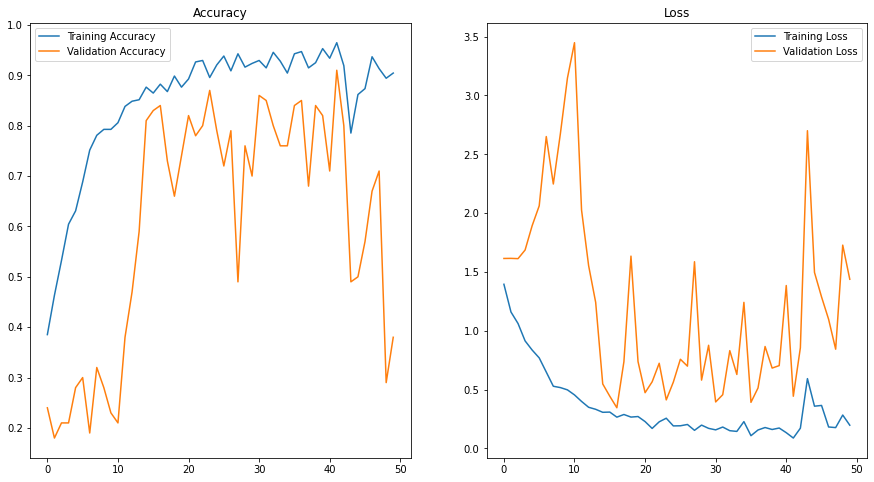

In [43]:
plotaccuracyandloss(num_epochs)

# Observation
The LSTM model performed the best with an accuracy of 96.47% and validation accuracy of 91% at epoch 42.
The model has been saved in this state model_init_2023-02-1015_41_15.693009/model-00042-0.08853-0.96471-0.44362-0.91000.h5

Comparing it with the Conv3D model, it has far lesser training parameters(35,413) vs (3,100,869) and took less time to train

# Load model and test

In [49]:
import time
from keras.models import load_model
model = load_model('model_init_2023-02-1015_41_15.693009/model-00042-0.08853-0.96471-0.44362-0.91000.h5')

In [50]:
g = generator(project_folder+'/val',val_doc,1,channels=3,enhanceandaugment=True )

In [51]:
batch_data, batch_labels=next(g)

Source path =  /home/datasets/Project_data/val ; batch size = 1 Channels =  3 Enhance And Augment =  True


In [52]:
batch_labels

array([[0., 0., 1., 0., 0.]])

In [53]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[2]


# Observation
The model predicted the class to be in index 2. The actual class in the batch label is also index 2.

# Experiment Result Table

<table>
   <tr><th>EXPERIMENT</th><th>MODEL</th><th>RESULT</th><th>DECISION + EXPLANATION</th></tr>
    <tr><td>1</td><td>Conv3D</td><td>Training Accuracy        : 95%
Validation Accuracy    : 39%
(Best validation Accuracy,Epoch:9/25)</td><td>Model is clearly overfit. Convolution layers with dropout layers and batch normalization are used. There was no augmentation and image enhancement done for images. We can increase batch size and use reduced dimension of image in our next experiment.</td></tr>

<tr><td>2</td><td>Conv3D</td><td>Training Accuracy        : 95.7%
Validation Accuracy    : 75%</td><td>Model is still overfit. This model has higher batch size of 40, 30 epochs with single channel of the image and reduced dimension of image. This helped improve the validation accuracy to 75% compared to model in experiment #1. Using only 1 channel data, reduced training time and memory footprint.</td></tr>
    
<tr><td>3</td><td>Conv3D</td><td>Training Accuracy        : 68.2%
Validation Accuracy    : 59%
(Best Accuracy,Epoch:26/30)</td><td>Model accuracy dropped. This model has higher number of convolution layers compared to model in experiment #2 and used all 30 images with all the 3 channels(RGB). Clearly, the augmentation and image enhancement is required to improve accuracy.</td></tr>
    
    
<tr><td>4</td><td>Conv3D</td><td>Training Accuracy        : 93%
Validation Accuracy    : 92%</td><td>This is an excellent model using Conv3D. Lower batch size and more layers with augmentation and image enhancement resulted in higher learning time per epoch. When batch size was increased beyond 10 then the model failed to train due to hardware memory limitations. </td></tr>
    
    
<tr><td>5</td><td>Conv2D + GRU</td><td>Training Accuracy        : 90% Validation Accuracy    : 64%</td><td>The model is overfit. This is Conv 2D and Gated Recurring Unit (GRU) based model with image of 120 x 120 with 3 channels. Let us try LSTM instead of GRU in our next experiment to improve the model’s validation accuracy.</td></tr>
    
    
<tr><td>6</td><td>Final Model
Conv2D + LSTM</td><td>Training Accuracy        : 96.47% Validation Accuracy    : 91%
(Best validation Accuracy,Epoch:42/50)</td><td>This is the best model for the Gesture Recognition considering the training accuracy of 96.47% and validation accuracy of 91%. Comparing it with the Conv3D model, it has far lesser training parameters(35,413) vs (3,100,869) and took less time to train.</td></tr>



</table>